# Biodegradability of Certain Molecular Structures   
I will be taking a look at the QSAR (Quantitative Structure Activity Relationships) Biodegradation Data Set, from the OpenML collection of datasets. The dataset features 41 attributes describing 1055 molecules, and whether or not they are ready biodegradable. The Milano Chemometrics and QSAR Research Group, part of the Department of Earth and Environmental Sciences for the University of Milano Bicocca in Italy sought to create a classifier that could predict ready biodegradability. The dataset mentioned above is the dataset they compiled from information on the website of the National Institute of Technology and Evaluation of Japan.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

X = np.genfromtxt(r'molecule dataset.arff',delimiter=',', skip_header=46, usecols=np.arange(0,41))
Y = np.genfromtxt(r'molecule dataset.arff',delimiter=',', skip_header=46, usecols=(41))

print(X.shape, Y.shape)

(1055, 41) (1055,)


I will take a look at this dataset using KNN, SVMs, and some variety of Ensemble Learning with decision trees. I will compare the accuracy of each and use them together to create a model that will attempt identify the biodegradability of molecular structures with over 90% accuracy.  
Biodegradation is the process of microorganisms breaking down organic matter to the base substances composing it. Using biodegradable materials leads to less waste, and greener processes for dealing with litter. Being able to use a model to estimate which molecular compounds are biodegradable would be extremely helpful in creating more reusable compounds. That in turn will allow for humanity to decrease how harshly we are treating the planet.   

# Nearest-Neighbor Classifier   
First we will be applying a rudimentary nearest number classifier to the dataset. This one is taken from the notes in the first few weeks of class.  
This simply takes a look at the closest molecule and returns that value. We are assuming that the data which is grouped together more closely is more closely related than farther data.

In [2]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2) #Distance between 2 points

class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, x):
        distances = [distance(x, self.X[i])
                     for i in range(len(self.X))] #An array of distances
        return np.argmin(distances) #return the index of the closest point
    def predict(self, x) :
        return self.y[self.get_nearest(x)]


def train_test_split(X, y, test_fraction=0.2, seed=42):
    test_len = round(len(X) * test_fraction)
    test_examples = np.zeros(len(X)) #Make an array of zeros
    test_examples[:test_len] = 1 #Add 1s until we reach the correct proportion
    rng = np.random.default_rng(seed)
    rng.shuffle(test_examples) #shuffle the order of the 1s and 0s
    return (X[test_examples == 0],
            y[test_examples==0],
            X[test_examples==1],
            y[test_examples==1]) #return 4 arrays based on the split we just created


Xtrain, ytrain, Xtest, ytest = train_test_split(X, Y)

nn = nearest_neighbor()
nn.fit(Xtrain, ytrain) #"train"
y_pred = np.array([nn.predict(Xtest[i]) for i in range(len(Xtest))]) #"test"

acc = np.sum(y_pred == ytest)/len(ytest)
print(f'The accuracy of the single nearest neighbor classifier is {acc:.3f}')


The accuracy of the single nearest neighbor classifier is 0.782


# K-Nearest Neighbor Classifier   
Nearest Neighbor is a quite simple classifier, but one way we can make it more accurate is by checking multiple neighbors. To do this, I will be using the built in scikit-learn functionality to compare the accuracy of the classifier over different quantities of neighbors to see how many neighbors yields the highest accuracy.  

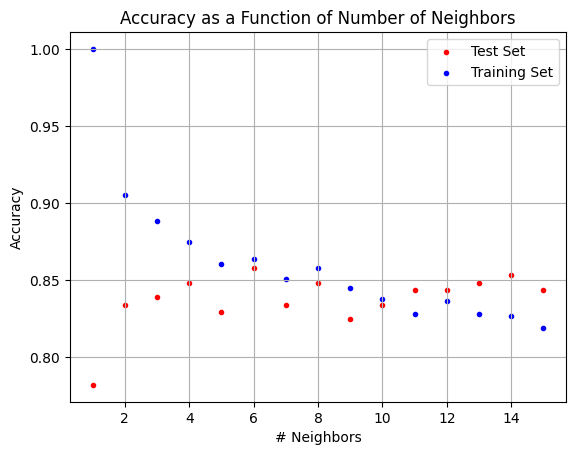

Highest test accuracy:  0.8578199052132701


In [3]:
from sklearn.neighbors import KNeighborsClassifier

num_neighs = np.arange(1, 16, 1, dtype=int)
accuraciesTrain = np.zeros(0, dtype=int, order='F')
accuracies = np.zeros(0, dtype=int, order='F')

for n in num_neighs:
  neigh = KNeighborsClassifier(n_neighbors=n)
  neigh.fit(Xtrain, ytrain)
  neigh.score(Xtest,ytest)
  accuraciesTrain = np.append(accuraciesTrain, neigh.score(Xtrain,ytrain))
  accuracies = np.append(accuracies, neigh.score(Xtest,ytest))

plt.scatter(num_neighs, accuracies, c='red', marker = ".", label='Test Set')
plt.scatter(num_neighs, accuraciesTrain, c='blue', marker = ".", label='Training Set')
plt.title('Accuracy as a Function of Number of Neighbors')
plt.ylabel('Accuracy')
plt.xlabel('# Neighbors')
plt.grid(True)
plt.legend(loc="best");
plt.show()
print('Highest test accuracy: ', np.amax(accuracies))

Sampling from multiple neighbors was able to increase the test score up to 7% when sampling from 6 neighbors. The accuracy on the training set continues to drop as the number of neighbors increases, so that tells me the data is probably not as separable as I had hoped. Next, I will take a look at a few data visualizations to try to glean some insight that can help me create a more accurate classifier.


147.0
-5.256


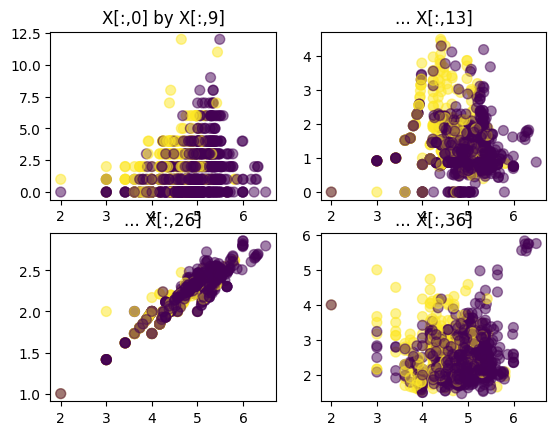

In [4]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(X[:,0], X[:,9], c=Y, alpha=0.5, s=50);
axs[0, 0].set_title('X[:,0] by X[:,9]')
axs[0, 1].scatter(X[:,0], X[:,13], c=Y, alpha=0.5, s=50);
axs[0, 1].set_title('... X[:,13]')
axs[1, 0].scatter(X[:,0], X[:,26], c=Y, alpha=0.5, s=50);
axs[1, 0].set_title('... X[:,26]')
axs[1, 1].scatter(X[:,0], X[:,36], c=Y, alpha=0.5, s=50);
axs[1, 1].set_title('... X[:,36]')
print(np.amax(X))
print(np.amin(X))

I graphed several individual features of the raw data above, and there isn't very much information to be gained. It looks like some of the individual features are pretty close to being linearly separable, but the two classes are still clustered very closely and there is a lot of overlap. Luckily, looking at the raw data one feature at a time isn't the only option available. Scikit has tool for visualizing data in higher dimensions, namely t-distributed Stochastic Neighbor Embedding (t-SNE) and Principal Component Analysis (PCA). I will use both of these, and perhaps they can help me learn something that can help me choose a preprocessing strategy for the data.

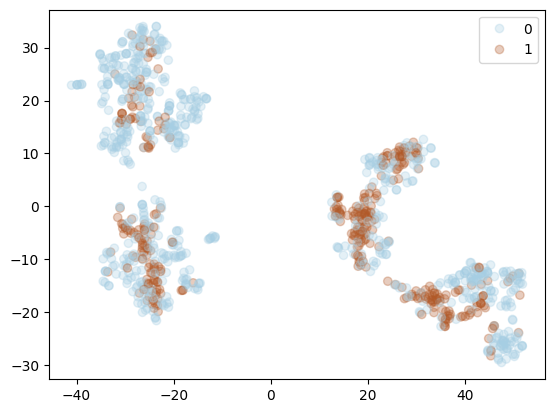

In [5]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, n_iter=1000, method='exact', learning_rate=500, perplexity=50).fit_transform(X)
scatter=plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.3, c=Y, cmap=plt.cm.Paired)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))

I used t-SNE first, and the data seems to have a considerable amount of overlap. Generally, the left side is predominantly blue dots, and the right side is predominantly orange, but there is definite mixing. The different clusters of data points don't seem to be separating the data by class, but it's not a disorganized mess. This leads me to believe that perhaps the data might be separable with a hyperplane after all, but I'll need to look around more.  

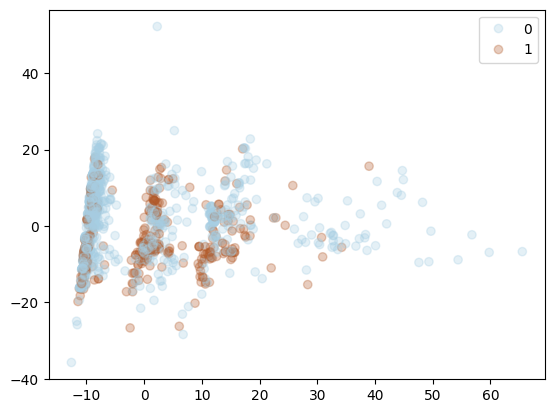

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
scatter=plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, c=Y, cmap=plt.cm.Paired)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))

After messing with the parameters for a while, the PCA is also pretty clustered, and it's difficult to tell whether or not the data is seperable or not. Once again there's a lot of blue on the left and more orange on the right, but there appear to be a decent quantity of outliers as well on the right, and the data appears to have a skew. There is a kernel version of PCA as well in the scikit libraries, so I want to take a look at that as well.

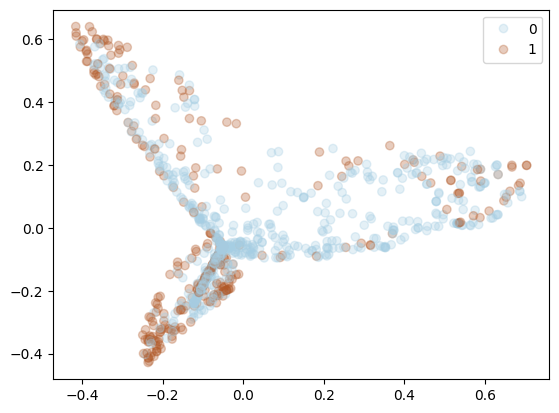

In [7]:
from sklearn.decomposition import KernelPCA
Kpca = KernelPCA(n_components=500, kernel='rbf')
X_kpca = Kpca.fit_transform(X)
scatter=plt.scatter(X_kpca[:, 0], X_kpca[:, 1], alpha=0.3, c=Y, cmap=plt.cm.Paired)
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))

After messing with the KernelPCA for a little bit, the most interesting graph was from the Radial Basis Function Kernel. Visually, it almost looks like a fish tail, but more interestingly: it appears that the data points labelled 1 (orange) are surrounding the other data points almost like a border. I'm definitely going to try using a radial kernel in the next section, but I'll want to try a few others as well in case a different one is more effective.

#Support Vector Machines  
In this next section, we will use SVMs to try and create a more accurate classifier than the KNN classifier from earlier. I will be using the Support Vector Classifier class provided by SciKit Learn, and comparing preprocessing strategies to attempt to tune the classifier as well as I can for this specific problem. The scikit learn implementation uses an rbf kernel by default, and that aligns with my estimates from looking at the data, but I will still be trying different kernels as well.  

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(Xtrain, ytrain)
print(clf.score(Xtest,ytest))

0.909952606635071


Using the Standard Scaler provides an improvement over both of the earlier nearest neighbor implementations. However, there are many other options for preprocessing the data. I will briefly discuss why I'm choosing each kernel.  
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-robust-scaler-section  
1) Maxabsscaler. This will scale the data down linearly so that the Maximum absolute value is 1. This does not recenter or stretch the data, so it is sensitive to outliers. Our data has outliers in it, so I'm assuming that this scaler will not perform as well as the standard scaler, but I'm still curious.  
2) Robustscaler centers and scales the data down. This scaler is very similar to Maxabsscaler, but it is not sensitive to outliers, so I'm expecting better performance from this one.  
3) Quantile transformer scales each feature independently to be either normally distributed or uniformly distributed. I was interested to try this one since it transforms each feature independently. I think I will look at uniform and normal separately to see how it affects the algorithm. I think this transforms the data to be between 0 and 1, so I wonder how this will affect the negative values that are in the original data.  
4) Power transformer scales the data to be more Gaussian. I will be using the Yeo-Johnson version of the algorithm since it supports positive and negative values in the data.  
I am going to perform tenfold cross-validation on each since the SVC is pretty quick and I want to be more thorough. I will be using stratified Kfold to accomplish this since it gives a more uniform representation of the data compared to not stratifying.  

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
accuracies1 = np.zeros(0, dtype=int, order='F')
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  clf1 = make_pipeline(MaxAbsScaler(), SVC(gamma='auto'))
  clf1.fit(X[train_index], Y[train_index])
  accuracies1 = np.append(accuracies1, clf1.score(X[test_index], Y[test_index]))
print("MaxAbsScaler Score: ", np.mean(accuracies1))

from sklearn.preprocessing import RobustScaler
accuracies2 = np.zeros(0, dtype=int, order='F')
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  clf2 = make_pipeline(RobustScaler(), SVC(gamma='auto'))
  clf2.fit(X[train_index], Y[train_index])
  accuracies2 = np.append(accuracies2, clf2.score(X[test_index], Y[test_index]))
print("Robust Scaler Score: ", np.mean(accuracies2))

from sklearn.preprocessing import QuantileTransformer
accuracies3 = np.zeros(0, dtype=int, order='F')
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  clf3 = make_pipeline(QuantileTransformer(n_quantiles=800, output_distribution='uniform'), SVC(gamma='auto'))
  clf3.fit(X[train_index], Y[train_index])
  accuracies3 = np.append(accuracies3, clf3.score(X[test_index], Y[test_index]))
print("Quantile Transformer (uniform distribution) Score: ", np.mean(accuracies3))

accuracies4 = np.zeros(0, dtype=int, order='F')
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  clf4 = make_pipeline(QuantileTransformer(n_quantiles=800, output_distribution='normal'), SVC(gamma='auto'))
  clf4.fit(X[train_index], Y[train_index])
  accuracies4 = np.append(accuracies4, clf4.score(X[test_index], Y[test_index]))
print("Quantile Transformer (normal distribution) Score: ", np.mean(accuracies4))

from sklearn.preprocessing import PowerTransformer
accuracies5 = np.zeros(0, dtype=int, order='F')
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  clf5 = make_pipeline(PowerTransformer(), SVC(gamma='auto'))
  clf5.fit(X[train_index], Y[train_index])
  accuracies5 = np.append(accuracies5, clf5.score(X[test_index], Y[test_index]))
print("Power Transform Score: ", np.mean(accuracies5))

accuracies6 = np.zeros(0, dtype=int, order='F')
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
  clf6 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf6.fit(X[train_index], Y[train_index])
  accuracies6 = np.append(accuracies6, clf6.score(X[test_index], Y[test_index]))
print("Standard Scaler Score: ", np.mean(accuracies6))

MaxAbsScaler Score:  0.7128391734052111
Robust Scaler Score:  0.8360287511230908
Quantile Transformer (uniform distribution) Score:  0.8578616352201257
Quantile Transformer (normal distribution) Score:  0.868230008984726
Power Transform Score:  0.8739802336028752
Standard Scaler Score:  0.8749056603773585


It looks like the standard scaler has the highest mean score. However, all of the classifiers performed pretty similarly except for the MaxAbsScaler which is sensitive to outliers, so as expected, it performed noticeably worse.  
Next, I want to run a gridsearch to tune the hyperparameters for the Support Vector Machines. The default is rbf, and looking at the data seems to indicate it will be effective, but I want to make sure.  

In [10]:
from sklearn.model_selection import GridSearchCV
#preprocess the data into separate vars
#gridsearch through the svc parameters afterwards
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)
svc_ = SVC(gamma='auto')
svc_params = [{'C': (1, 5, 10), 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'shrinking': (True, False)}]
grid_svc = GridSearchCV(svc_, svc_params, n_jobs=-1, cv=10, scoring='accuracy')
grid_svc.fit(scaledX, Y)

print(grid_svc.best_params_)
print(grid_svc.best_score_)

{'C': 5, 'kernel': 'rbf', 'shrinking': True}
0.8785714285714287


As expected, rbf was the best kernel for the SVC. I want to try to get the accuracy above 90, so I'm going to look at another classifer, then try ensemble voting methodologies to increase the accuracy.  
I want to continue by looking into random forests. I will do another gridsearch right off the bat to tune the parameters.  

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(oob_score=True, n_estimators=100, max_features=1)
forest_params = [{'max_depth': list(range(10, 30, 5)), 'criterion': ('gini', 'entropy', 'log_loss')}]
clf = GridSearchCV(rfc, forest_params, n_jobs=-1, cv=10, scoring='accuracy')

#This may take a minute or two to run
clf.fit(X, Y)

print(clf.best_params_)
print(clf.best_score_)

{'criterion': 'gini', 'max_depth': 25}
0.860575022461815


Random forests also scored pretty well. I will use this alongside kNN and SVMs to construct an ensemble that will hopefully acquire higher than 90% accuracy after voting. Scikit has a votingClassifier for majority rule ensemble voting. I will be using that with the hyperparameters I gathered earlier in the paper. I will also be using 'soft' voting since my classifiers have been carefully tuned beforehand.

In [12]:
#Pulling the original data back in
X = np.genfromtxt(r'molecule dataset.arff',delimiter=',', skip_header=46, usecols=np.arange(0,41))
Y = np.genfromtxt(r'molecule dataset.arff',delimiter=',', skip_header=46, usecols=(41))

from sklearn.ensemble import VotingClassifier

svc_final = SVC(gamma='auto', C=5, kernel='rbf', shrinking=True, probability=True)

nei_final = KNeighborsClassifier(n_neighbors=6)

rfc_final = RandomForestClassifier(oob_score=True, n_estimators=100, max_features=1, criterion='log_loss', max_depth=20)

models = [('knn', nei_final),('svm',make_pipeline(StandardScaler(), svc_final)),('rfc', rfc_final)]
ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(X,Y)
print(ensemble.score(X,Y))

0.95260663507109


I managed to meet my goal of making a classifier with higher than 90% accuracy. Next, I want to see exactly where the classifier is failing. I will show the confusion matrix and calculate accuracy, precision, recall, etc.

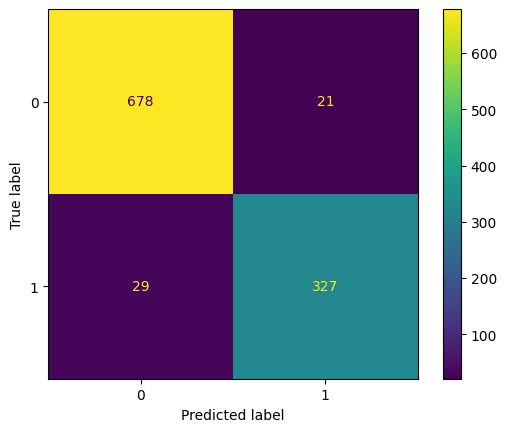

In [13]:
ensem_y = ensemble.predict(X)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y, ensem_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [14]:
print('Precision: ', 681/(681+27))
print('Recall: ', 681/(681+18))
print('Accuracy: ', (681+329)/(681+27+18+329))
print('Balanced Accuracy: ', 0.5*((681/(681+18))+(329/(329+27))))

Precision:  0.961864406779661
Recall:  0.9742489270386266
Accuracy:  0.957345971563981
Balanced Accuracy:  0.9492031152047066


Using multiple classifiers then having them vote reduced the noise in the individual classifiers and allows for a more uniform distribution in the confusion matrix. There were a pretty even amount of false positives and false negatives. Data with this many features is difficult to generalize to, and there are many environmental factors in biodegradability, so I'm quite satisfied with reaching around 95% accuracy. If I were to do this again with more time, I think I would try to utilize eXtreme Gradient Boosting (aka XGBoost). XGBoost is another ensemble learning method with high performance in supervised classification tasks. I would also have been interested in spending more time preprocessing the data. Using SVMs I could have found which features contributed the least to the classification of the molecules, and I could have removed that data from the models to make them simpler and easier to work with.  

Alex Guentchev
CS345 Project
5/3/2024